# 前提知識
## Pauli群, Clifford ゲート, non-Cliffordゲート
ある量子ビットのHilbert空間$\mathcal{H}$に作用する演算子に関する基底として、Pauli演算子$\{I, X, Y, Z\}$がある：
\begin{equation}
I := \begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix}, 
X := \begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix},
Y := \begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix},
Z := \begin{pmatrix} 1 & 0 \\ 0 & -1\end{pmatrix}
\end{equation}
同様に、$N$量子ビット系のHilbert空間$\mathcal{H}_N := \mathcal{H}^{\otimes N}$においては、Pauli演算子積$\{I, X, Y, Z\}^{\otimes N}$が完全基底をなすことが知られている。
つまり、$\mathcal{H}_N$に作用する線形演算子$L \in \mathcal{L}(\mathcal{H}_N)$に対して、$L = \sum_i c_i P_i$を満たす係数の集合$\{c_i\}_i$が一意に定まる。
また、位相自由度を付した $\mathcal{P}_N := \{\pm1, \pm i\} \times \{I, X, Y, Z\}^{\otimes N}$は群をなし、Pauli群と呼ばれている。

Clifford演算子(もしくはCliffordゲート)とは、Pauli群をPauli群に移すような線形演算子のことである。具体的には、Clifford演算子の集合は
\begin{equation}
\mathcal{C}_N := \{U \in \mathcal{U}_N | U P U^\dag \in \mathcal{P}_N, \forall P\in\mathcal{P}_N\}
\end{equation}
と定義されている。特に、位相自由度を取り除いた集合$\mathcal{C}_N/e^{i \phi}$を指してClifford群と呼ぶことが多い。

Cliffordゲートのみから構成された量子回路をClifford回路と呼ぶ。ここで、Clifford回路は古典計算機で効率的に (つまり時間計算量、空間計算量がO(${\rm poly}(N)$)で)シミュレートできることが知られている (Gottesman-Knillの定理)。
つまり、Clifford回路だけでは量子加速が得られない (例えばShorのアルゴリズムによる指数加速が得られない)ため、non-Cliffordゲートを追加する必要がある。

とはいえ、誤り耐性量子計算(Fault-tolerant quantum computing, FTQC)では、自由になんでも追加できるわけではなく、実装上の制約が付いている。
最も現実的な選択肢の一つが、Tゲートと呼ばれるnon-Cliffordゲートを用いるタイプである。
CliffordゲートとTゲートを用いて一般の量子回路を書き下すことを、Clifford+T分解やClifford+Tコンパイルと呼ぶ。


## Clifford+T compilation

FTQCの回路を設計する際には、まず量子回路を連続的なパラメータを含む形で構成してからClifford+T分解することが多い。
頻出するゲートとして、Pauli演算子に関する回転ゲート$e^{-i \theta P}~(P\in\mathcal{P}_N)$が挙げられる。ここで、任意のPauli回転ゲートは、up to Cliffordで Pauli Z rotationと等価、つまり、あるClifford演算子$C\in\mathcal{C}_N$が存在して$C e^{-i\theta P} C^\dag = e^{-i \theta Z}~(Z=\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix})$と書けることに注意すると、1量子ビットのPauli Z rotationのみに関するClifford+T分解を考えれば十分であることがわかる。
具体的には、回転角$\theta$を定めた際に、以下のように1量子ビットに作用するゲートを考える：
\begin{equation}
R_z(\theta) = \exp\left( -i \frac{\theta}{2} Z\right).
\end{equation}

実は、一般の$\theta$に関して厳密に実装をすることはできない。
なぜなら、Cliffordゲートは離散群をなし、$k$個のTゲートを含むようなゲートの集合から生成される群（level-$(k+2)$ Clifford hierarchy）もまた、離散群をなすためである。
これは一見悪いニュースに聞こえるが、実は、Tゲートの個数に対して指数的に要素数が増え、ユニタリ群全体を稠密に埋め尽くしていく(Solovay-Kitaevの定理)という性質がある。
そこから類推すると、精度$\epsilon$に関して深さ$O({\rm polylog(1/\epsilon)})$の回路によって近似実装が可能なんじゃないかという気がしてくる。

実際、$R_z$ゲートを精度$\epsilon$でClifford+T分解するための（ほぼ）最適な分解方法が、
Ross&Selinger ('14) [1] によって提案されており、Tゲートの数が$3\log_2(1/\epsilon)+K + O(\log\log(1/\epsilon))$($K$は定数)で与えられることが知られている。このスケーリングは、loglog補正を除いてoptimalであることも示されているので、界隈にとってスタンダードな手法といえる。
ただ、実装が公開[2]されてものの、Haskel言語に基づいており、他言語から呼び出す際には非常に使いづらい。
そこで、pythonで気軽に使えるようなコードを整備するのが我々の目標である。

## コンテストの問題概要
Ross-Selingerアルゴリズムは、以下のようなステップで構成されている。

0. 入力の決定: 回転角度$\theta$, 精度$\epsilon$
1. 近似ユニタリ$\tilde{U}$の計算：$\|R_z(\theta) - \tilde{U}\| \geq \epsilon$であって、有限個のTゲートを用いて実装可能なユニタリ$\tilde{U}$を列挙する。その中から、必要な$T$ゲートの数が最小であるものを求める。
2. コンパイル：$\tilde{U}$を厳密にClifford+T分解する。

ステップ1に対応するコード実装は完了しており、`gridsynthpy`として与えられている。
課題は、ステップ2を実装することである。ステップ2の内容は論文[3]で閉じているので、これ読み解き、効率的な実装をするのがコンテスト内容となる。

[1] Ross and Selinger, [arXiv:1403.2975](https://arxiv.org/abs/1403.2975) 

[2] [gridsynth](https://www.mathstat.dal.ca/~selinger/newsynth/)

[3] Kliuchnikov, Maslov, Mosca, [arXiv:1206.5236](https://arxiv.org/abs/1206.5236)

# ゴールとなる入出力の確認

In [1]:
from utils import circuit_to_unitary
from qulacs import QuantumCircuit # 量子計算のための数値計算ライブラリ, pip install可能
import numpy as np

theta=0.3 #量子回路のパラメータ
qc = QuantumCircuit(1)
qc.add_RZ_gate(0, -theta) # ライブラリ中の定義は Rz = exp(+1j * theta/2 * Z)なので、符号をつける必要がある

u_exact = circuit_to_unitary(qc)

# 定義の正しさを確認
np.allclose(np.diag([np.exp(-1j * theta/2), np.exp(+1j * theta /2)]), u_exact)

True

分解では、Pauliゲートのほか、
$S = \begin{pmatrix} 1 & 0 \\ 0 & i\end{pmatrix} \simeq R_z(\pi/4)$, $H=\begin{pmatrix}1/\sqrt{2} & 1/\sqrt{2} \\ 1/\sqrt{2} & -1/\sqrt{2} \end{pmatrix}$, $T = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4}\end{pmatrix} \simeq R_z(\pi/8)$が登場する。
ここで$\simeq$はglobal phaseを除いて等しい、という意味で用いた。

In [3]:
# 以下はRoss-Selingerの gridsynthを用いた際の出力 (最終的に求めたい答え)になる
# https://www.mathstat.dal.ca/~selinger/newsynth/
# インストールしたのちに "gridsynth 0.3 -d 3" を実行すると eps=1e-3に対応する計算結果が得られる

# eps = 1e-1 でのコンパイル結果
gateword1 = "TSHTHTSHTHTHTHTSHTHSSSWWWWWW" # W = global phase (exp(1j * pi/4))
# 量子回路で左から T-S-H-T-...の順にゲートを追加したものに相当

# eps = 1e-2 でのコンパイル結果
gateword2 = "SHTHTHTHTHTHTHTSHTSHTSHTHTHTSHTSHTSHTHTHTHTHTHTHSSSWW"

# eps = 1e-3 でのコンパイル結果
gateword3 = "SHTHTHTSHTHTSHTHTSHTSHTSHTSHTSHTSHTHTHTSHTHTSHTHTHTHTSHTHTSHTSHTHTHTSHTHTHTSHSSSWWWW"

# eps = 1e-10 でのコンパイル結果
gateword10 = "HTSHTSHTHTHTHTSHTSHTHTSHTHTSHTSHTHTHTSHTSHTSHTSHTHTSHTSHTHTSHTSHTHTSHTHTHTSHTHTHTSHTHTSHTHTHTSHTHTHTHTSHTSHTSHTHTSHTSHTSHTSHTHTSHTSHTHTSHTSHTHTHTSHTHTSHTHTSHTHTSHTHTSHTHTHTSHTHTSHTHTSHTHTHTHTSHTHTHTSHTSHTHTSHTHTHTSHTHTHTHTSHTHTSHTSHTHTHTHTHTHTHTSHTHXSSSWWWWWWW"

print("T count:")
print(gateword1.count("T"))
print(gateword2.count("T"))
print(gateword3.count("T"))
print(gateword10.count("T"))

T count:
8
20
30
100


In [4]:
from utils import word_to_gate, circuit_to_unitary
import mpmath

def unitary_error(u1, u2):
    if type(u1) != type(u2):
        if isinstance(u1, mpmath.matrix):
            u2 = mpmath.matrix(u2)
        else:
            u1 = mpmath.matrix(u1)
            
    E = u1 - u2
    return mpmath.sqrt(mpmath.fabs(E[0, 0] * E[1, 1] + E[0, 1] * E[1, 0]))


u_rs1 = circuit_to_unitary(word_to_gate(gateword1, backend = "qulacs")) 
u_rs2 = circuit_to_unitary(word_to_gate(gateword2, backend = "qulacs")) 
u_rs3 = circuit_to_unitary(word_to_gate(gateword3, backend = "qulacs")) 
u_rs10 = circuit_to_unitary(word_to_gate(gateword10, backend = "qulacs")) 

error_rs1 = unitary_error(u_exact, u_rs1)
error_rs2 = unitary_error(u_exact, u_rs2)
error_rs3 = unitary_error(u_exact, u_rs3)
error_rs10 = unitary_error(u_exact, u_rs10)

print("Error: ")
print(f"{float(error_rs1):.8e}")
print(f"{float(error_rs2):.8e}")
print(f"{float(error_rs3):.8e}")
print(f"{float(error_rs10):.8e}")

Error: 
2.56200911e-02
5.03389660e-03
2.54739990e-04
7.45911022e-11


## ステップ1の出力を確認
ステップ1に関しては、[論文](https://arxiv.org/abs/1403.2975)の実装方法を日本語にまとめた資料をnote.pdfとして準備した。
現状、eps=1e-10にて5倍程度の差がある(論文のTable 1を参照)。
要因の一つとしては、論文中のAlgorithm 7.6.2における解のチェックについては並列化が可能だが、我々のpygridsynthでは未実装であることなどが考えられる。

ステップ2よりもステップ1の高速化に興味がある参加者が多い場合、その旨をご連絡いただければ別問題としての開催も検討します。

In [20]:
import qulacs
import sys
import mpmath # controls the precision

def generate_unitary(sol):
    u, t = sol
    return mpmath.matrix([[u.toComplex, -t.conj.toComplex],
                          [t.toComplex, u.conj.toComplex]])


def generate_target_Rz(theta):
    """
    return U = exp(-1j * theta/2 * Z)
    """

    return mpmath.matrix([[mpmath.exp(- 1.j * theta / 2), 0],
                          [0, mpmath.exp(1.j * theta / 2)]])

from pygridsynth import gridsynth

mpmath.mp.dps = 130 # number of digits
mpmath.mp.pretty = True

theta_ = mpmath.mpmathify('0.3')
epsilon1 = mpmath.mpmathify('1e-1')
epsilon2 = mpmath.mpmathify('1e-2')
epsilon3 = mpmath.mpmathify('1e-3')
epsilon10 = mpmath.mpmathify('1e-10')

verbose = False

sol1 = gridsynth(theta=theta_, epsilon=epsilon1, verbose=verbose, )
sol2 = gridsynth(theta=theta_, epsilon=epsilon2, verbose=verbose, )
sol3 = gridsynth(theta=theta_, epsilon=epsilon3, verbose=verbose, )
sol10 = gridsynth(theta=theta_, epsilon=epsilon10, verbose=verbose, )

In [21]:
%%time
sol10 = gridsynth(theta=theta, epsilon=epsilon10, verbose=verbose, ) #Haskel実装では 20ms程度 (cf. 論文のTable 1)

CPU times: user 102 ms, sys: 2.26 ms, total: 105 ms
Wall time: 104 ms


In [15]:
u_sol1 = generate_unitary(sol1)
u_sol2 = generate_unitary(sol2)
u_sol3 = generate_unitary(sol3)
u_sol10 = generate_unitary(sol10)

# ユニタリを計算するステップ1では候補を複数探索しているため、原論文のHaskelコードと一致しないケースもある
print(np.isclose(float(error_rs1), float(unitary_error(u_sol1, u_exact))))
print(np.isclose(float(error_rs2), float(unitary_error(u_sol2, u_exact))))
print(np.isclose(float(error_rs3), float(unitary_error(u_sol3, u_exact))))
print(np.isclose(float(error_rs10), float(unitary_error(u_sol10, u_exact))))

True
False
True
True


## 課題
上で見たように、ステップ1のコードにより、
\begin{equation}
\tilde{U} = \begin{pmatrix} u & -t^\dag \\ t & u^\dag \end{pmatrix}
\end{equation}
を与える$u,t \in \mathbb{Z}[1/\sqrt{2}, i] = \{a \omega^3, b \omega^2+ c\omega + d | a, b, c, d \in \mathbb{D}\}$がわかっている。
ここで、$\omega:= e^{i \pi/4} = (1+i)/\sqrt{2}, \mathbb{D} = \mathbb{Z}[\frac{1}{2}] = \{\frac{a}{2^k}| a\in \mathbb{Z}, k\in \mathbb{N}\}$である。

課題(ステップ2)は、[Kliuchnikov-Maslov-Mosca](https://arxiv.org/abs/1206.5236)のalgorithm 1の実装である。
theta = 0.3, eps = 1e-1, 1e-2, 1e-3, 1e-10に関する実行時間をベンチマークし、まとめて提出していただく。


もちろん、アルゴリズムの実装だけでなく、より効率的な手法の提案も大歓迎です。
コンテスト時点での言語は問いませんが、 最終的には gridsynthpyに組み込めるようにしたいと思っています。

In [17]:
def your_code(sol):

    #u, t = sol[0].toComplex, sol[1].toComplex
    #unitary = generate_unitary(sol)

    # generate gateword
    gateword = ...

    return gateword

In [ ]:
%%time 
my_gateword1 = your_code(sol1)
assert my_gateword1 == gateword1

In [ ]:
%%time 
my_gateword2 = your_code(sol2)
# this does not coincide with gateword2

In [ ]:
%%time 
my_gateword3 = your_code(sol3)
assert my_gateword3 == gateword3

In [ ]:
%%time 
my_gateword10 = your_code(sol10)
assert my_gateword10 == gateword10

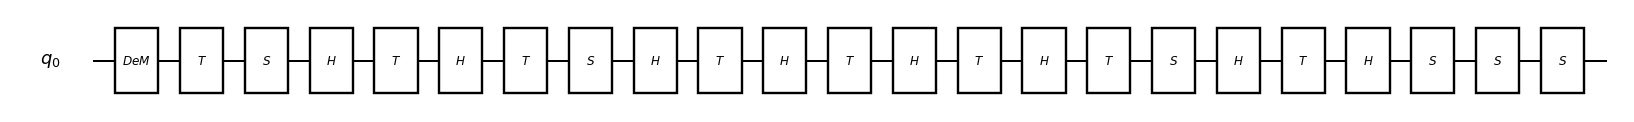

In [16]:
# 視覚的なデバッグに役に立つかもしれない
from qulacsvis import circuit_drawer

qc = word_to_gate(gateword1)
circuit_drawer(qc, "mpl")
# DeMは global phaseに対応する処理